<font size = 6>**Detect eye blinks using Pupil Labs' blink detection pipeline**

Detecting eye blinks accurately is a crucial step for many eye tracking applications. On the one hand, during eye blinks, the pupil is temporarily occluded. This not only prevents external visual information from entering the retina and being processed further up the visual hierarchy, but also severely impairs gaze estimation. On the other hand, blink statistics, such as blink rate, can serve as a relevant physiological, clinical, and cognitive parameter. This Alpha Lab demonstrates how to use the Pupil Labs blink detection pipeline to **detect eye blinks in a given recording** (Part 1) and how to **detect eye blinks in quasi real time** (Part 2).

If you want to read a more technical summary of the Pupil Labs blink detection algorithm, you can find a short white paper in the documentation: PROVIDE LINK TO DOCUMENTATION HERE

The code accompanying this notebook can be found here: github.com/pupil-labs/


**<font size = 5>Part 1:** Offline blink detection


First, we import the necessary function from the blink_detector.blink_detector module:

In [1]:
from blink_detector.blink_detector import blink_detection_pipeline

Next, we specify the path to the example recording that we want to analyze. You can replace this path with the path to your own recording:

In [2]:
recording_path = "blink_detector/data/padel_tennis_neon_03-2ded8f56"

In this example, the recording is from a Neon device. If you are working with Pupil Invisible, you can set the is_neon parameter to False. To detect blinks, we call the blink_detection_pipeline function and pass the recording path and the is_neon parameter. The function returns a generator object which can be converted into a list of blink events:

In [3]:
blink_events = list(blink_detection_pipeline(recording_path, is_neon=True))

And that's it! Now that we have detected the blink events, we can perform further analysis or extract useful information from them. The following code calculates and prints the number of blinks and the mean blink duration:

In [4]:
import numpy as np

print(
    f"Number of blinks: {len(blink_events)}\n"
    f"Mean blink duration: {np.mean([(blink_event.end_time-blink_event.start_time)/1e9 for blink_event in blink_events])}\n"
)

Number of blinks: 61
Mean blink duration: 0.2649380819672132



Next, let's visualize the timeline of the detected blinks:

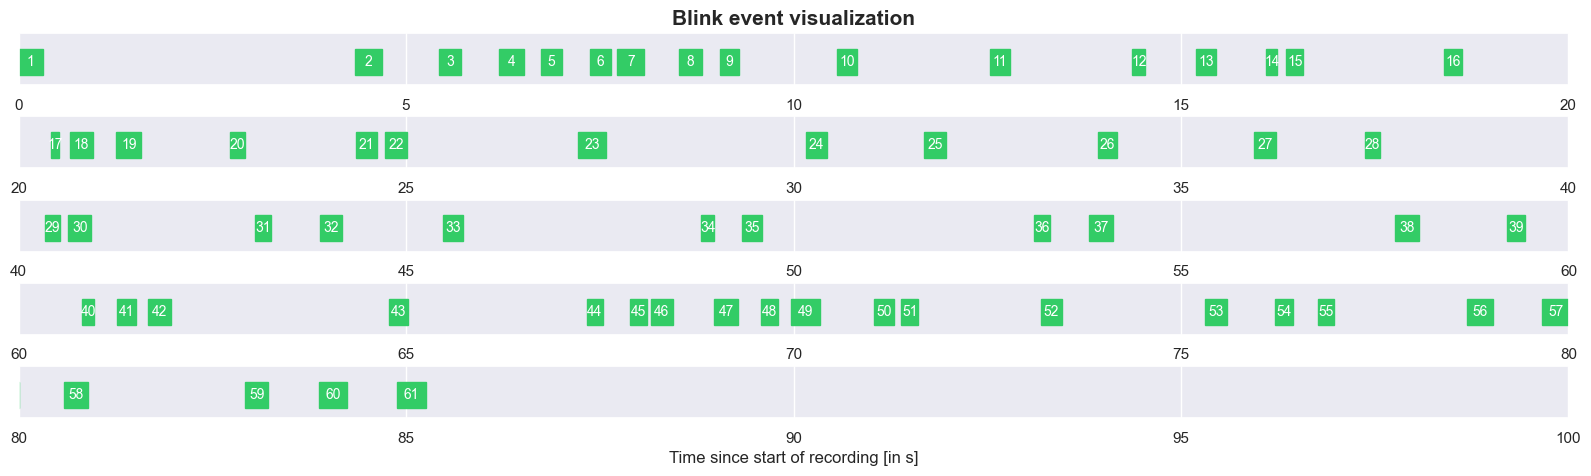

In [5]:
from blink_detector.helper import visualize_blink_events

visualize_blink_events(recording_path, blink_events)

We can now see how the 61 detected blinks are distributed over time.

We can also visualize the blinks in an animation. For this, a white square is drawn into the center of the eye video frames for those frames that were marked as part of a blink event. The following code snippet imports necessary functions and processes the recording:

In [8]:
from IPython.display import HTML
from blink_detector.helper import generate_animation
from blink_detector.helper import process_recording

left_eye_images, right_eye_images, timestamps = process_recording(
        recording_path, is_neon=True
    )

video_length = 3000 # in frames (with 200 fps)

The process_recording function takes the recording path and the is_neon parameter and returns the left and right eye images along with the corresponding timestamps. In order to create an animation, we define the length of the video. Note that generating long animations can take a while, which is why we restrict this to 3000 frames, corresponding to the first 15s of the recording.

We next iterate through each blink event and extract the onset and offset indices for each event:

In [9]:
blink_indices = np.zeros_like(timestamps)

# extract onset and offset indices for each blink event
for blink_event in blink_events:
    on = np.where(blink_event.start_time == timestamps)[0]
    off = np.where(blink_event.end_time == timestamps)[0]
    blink_indices[int(on) : int(off)] = 1

After that, we generate the animation using the generate_animation function and pass the left and right eye images, as well as the blink indices:

In [ ]:
anim = generate_animation(
    left_eye_images[:video_length, :, :],
    right_eye_images[:video_length, :, :],
    indices=blink_indices[:video_length],
)

Finally, we display the animation using the HTML widget:

In [ ]:
HTML(anim.to_html5_video())

<font size = 5><b>(2) Blink detection in real time using PL's realtime API</b>

<font size = 3>In the next steps, blink events will be detected in (quasi) real-time using Pupil Lab's Real Time API. <br>
Note that the temporal resolution of the blink detection is restricted by the optical flow parameters<br>
(i.e., the number of layers and the layer interval), as well as postprocessing parameters (e.g. the minimum blink duration).

**(2.1) Load all relevant modules and functions**

In [1]:
from blink_detector.helper import video_stream
from blink_detector.blink_detector import blink_detection_pipeline
from pupil_labs.realtime_api.simple import discover_one_device
import nest_asyncio
from itertools import tee

**(2.2) Set up real time API**

In [2]:
import time

# needed when running in notebook
nest_asyncio.apply()

# calling the functions shortly after one another can cause an error
time.sleep(1)

device = discover_one_device()

Printing the device name and its IP helps to make sure that the discovered device is indeed <br>
the device you would like to connect with.

In [3]:
print(f"Phone IP address: {device.phone_ip}")
print(f"Phone name: {device.phone_name}")

Phone IP address: 192.168.20.132
Phone name: Kai's Companion


**(2.3) Set up real-time data stream**

In [4]:

# create three independent generator objects from the video stream
stream_left, stream_right, stream_ts = tee(video_stream(device), 3)

left_images = (left for left, _, _ in stream_left)
right_images = (right for _, right, _ in stream_right)

# timestamps need to be converted to ns
timestamps = (1e9 * timestamp for _, _, timestamp in stream_ts)

**(2.4) Run blink detection pipeline**

Get classifier path

In [5]:
import pathlib
# from blink_detector.helper import get_clf_path
# clf_path = get_clf_path(is_neon=True)
clf_path = pathlib.Path("/Users/tpfeffer/projects/real-time-blink-detection/blink_detector/weights/xgb_neon_171.sav")

Detect and print blink events in (quasi) real-time

In [ ]:
for blink_events in blink_detection_pipeline(
    left_images, 
    right_images, 
    timestamps, 
    clf_path
):
    print(blink_events)